In [2]:
from matplotlib import cm, colors, pyplot as plt
import metaworld
import torch
from torch import nn
import copy
import ray
import numpy as np
import seaborn as sns

from nupic.embodied.utils.garage_utils import create_policy_net
from nupic.embodied.multitask.samplers.gpu_sampler import SamplerEvalOnly
from nupic.embodied.multitask.hooks.sparse_viz import (
    AverageSegmentActivationsHook,
    HiddenActivationsPercentOnHook,
    CombinedSparseVizHook
)

from garage.experiment.task_sampler import MetaWorldTaskSampler

from nupic.embodied.utils.parser_utils import merge_args
sys.path.append("/Users/lsouza/nta/nupic.embodied/projects/multitask")
from args_parser import create_exp_parser
from experiments import CONFIGS

import numpy
import torch

from scipy.spatial.distance import cosine
from collections import Counter, defaultdict

objc[34271]: Class GLFWApplicationDelegate is implemented in both /Users/lsouza/.mujoco/mujoco200/bin/libglfw.3.dylib (0x1254fa778) and /Users/lsouza/miniconda3/envs/multitask/lib/python3.8/site-packages/glfw/libglfw.3.dylib (0x1255b3740). One of the two will be used. Which one is undefined.
objc[34271]: Class GLFWWindowDelegate is implemented in both /Users/lsouza/.mujoco/mujoco200/bin/libglfw.3.dylib (0x1254fa700) and /Users/lsouza/miniconda3/envs/multitask/lib/python3.8/site-packages/glfw/libglfw.3.dylib (0x1255b3768). One of the two will be used. Which one is undefined.
objc[34271]: Class GLFWContentView is implemented in both /Users/lsouza/.mujoco/mujoco200/bin/libglfw.3.dylib (0x1254fa7a0) and /Users/lsouza/miniconda3/envs/multitask/lib/python3.8/site-packages/glfw/libglfw.3.dylib (0x1255b37b8). One of the two will be used. Which one is undefined.
objc[34271]: Class GLFWWindow is implemented in both /Users/lsouza/.mujoco/mujoco200/bin/libglfw.3.dylib (0x1254fa818) and /Users/lsou

# MLP-Dendrites Comparison

In [3]:
class HiddenActivationsPercentOnHookMLP(HiddenActivationsPercentOnHook):
    def attach(self, network):
        # network.module.mean_log_std._layers[1].layer_normalization.register_forward_hook(self.activation_hook_fn)
        network.module.mean_log_std._layers[1].register_forward_hook(self.activation_hook_fn)             

def get_updated_policy(policy, hook):
    with torch.no_grad():
        updated_policy = copy.deepcopy(policy)
    updated_policy.eval()
    hook(updated_policy)
    return updated_policy

def init_experiment(state_path, config, mlp=False, average_hook=False):
    mt_env = metaworld.MT10(seed=41)
    train_task_sampler = MetaWorldTaskSampler(
        mt_env, "train", add_env_onehot=True
    )
    mt_train_envs = train_task_sampler.sample(10)
    env = mt_train_envs[0]()

    exp_parser = create_exp_parser()
    trainer_args = merge_args(exp_parser.parse_dict(CONFIGS[config]))

    env = mt_train_envs[0]()
    policy = create_policy_net(env_spec=env.spec, net_params=trainer_args)

    if state_path is not None:
        experiment_state = torch.load(state_path, map_location=torch.device('cpu'))
        policy.load_state_dict(experiment_state["algorithm"]["policy"])

    if mlp:
        print("Using MLP network")
        hook = HiddenActivationsPercentOnHookMLP
    elif average_hook:
        hook =AverageSegmentActivationsHook
    else:
        hook = HiddenActivationsPercentOnHook

    net = get_updated_policy(policy, hook)

    sampler = SamplerEvalOnly(
        agent=net,
        envs=mt_train_envs,
        max_episode_length=env.spec.max_episode_length,
        cpus_per_worker=0.5,
        gpus_per_worker=0,
        workers_per_env=1,
        seed=42,
    )

    return net, sampler

def collect_data(net, sampler, num_eval_eps=1):

    samples, hook_data = sampler.obtain_exact_episodes(
        n_eps_per_worker=num_eval_eps,
        agent_update=net,
        collect_hook_data=True,
    )

    data = next(iter(hook_data.values()))

    return samples, data

def get_distances(data):
    distances = np.zeros((10,10))
    for i in range(len(data)):
        for j in range(len(data)):
            average_acts_i = data[i].mean(dim=0)
            average_acts_j = data[j].mean(dim=0)
            distances[i][j] = cosine(average_acts_i, average_acts_j)

    return distances

def calculate_avg_distances(data, num_samples=40):
    distances_same_task = []
    distances_other_task = []
    for i in range(len(data)):
        for j in range(len(data)):
            if i == j:
                distances_per_type = distances_same_task
            else:
                distances_per_type = distances_other_task
            acts_i = data[i]
            acts_j = data[j]
            for x in range(num_samples):# range(acts_i.shape[0]):
                for y in range(num_samples): # range (acts_j.shape[0]):
                    distances_per_type.append(cosine(acts_i[x, :], acts_j[y, :]))
    print("\nDistance same task: {:.4f}, across tasks: {:.4f}\n".format(
        np.mean(distances_same_task), np.mean(distances_other_task)
    ))          

def report(state_path, config, mlp=False, num_samples=100, average_hook=False):
    net, sampler = init_experiment(state_path, config, mlp=mlp, average_hook=average_hook)
    data = collect_data(net, sampler)
    distances = get_distances(data)
    calculate_avg_distances(data, num_samples=num_samples)
    sns.heatmap(distances)
    return net, sampler, data, distances

def get_network(state_path, config, mlp=False, num_samples=100, average_hook=False):
    net, sampler = init_experiment(state_path, config, mlp=mlp, average_hook=average_hook)
    return net, sampler




## Comparisons


Distance same task: 0.4117, across tasks: 0.8861



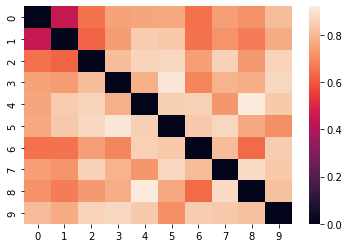

In [21]:
state_path = "/Users/lsouza/nta/results/no_preprocess3-wouv839/experiment_state.p"
config = "no_preprocess6"
report(state_path, config, mlp=False);

Using MLP network

Distance same task: 0.4253, across tasks: 0.8937



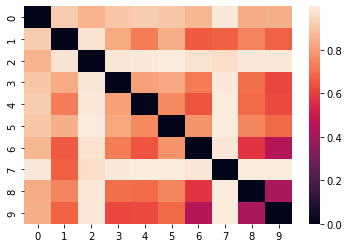

In [22]:
state_path_mlp = "/Users/lsouza/nta/results/mlp_final-dtbi450/experiment_state.p"
config_mlp = "mlp_final"
report(state_path_mlp, config_mlp, mlp=True);

Using MLP network

Distance same task: 0.0668, across tasks: 0.9314



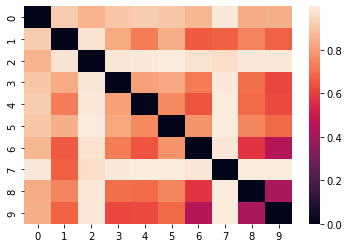

In [24]:
def report(state_path, config, mlp=False, num_samples=100, average_hook=False):
    net, sampler = init_experiment(state_path, config, mlp=mlp, average_hook=average_hook)
    data = collect_data(net, sampler)
    distances = get_distances(data)
    calculate_avg_distances(data, num_samples=num_samples)
    sns.heatmap(distances)
    return net, sampler, data, distances

net, sampler, data, distances = report(state_path_mlp, config_mlp, num_samples=10, mlp=True)

In [45]:
state_path = "/Users/lsouza/nta/results/no_preprocess3-wouv839/experiment_state.p"
config = "no_preprocess6"
net, sampler = init_experiment(state_path, config)
samples, data = collect_data(net, sampler, num_eval_eps=3)

/Users/lsouza/miniconda3/envs/multitask/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/Users/lsouza/miniconda3/envs/multitask/lib/python3.8/site-packages/garage/experiment/deterministic.py:36: UserWarning: Enabeling deterministic mode in PyTorch can have a performance impact when using GPU.
  warnings.warn(


In [46]:
for task_id in range(10):
    print(len(data[task_id]))

1500
1500
1500
1500
1500
1500
1500
1500
1500
1500


In [122]:
from collections import Counter, defaultdict
task_ids = {}
task_aggs = {}

# dictionary: task -> list of samples. 
for task_id in range(10):
    task_ids[task_id] = torch.zeros(data[0][0].shape)
    task_aggs[task_id] = torch.zeros(data[0][0].shape)
    num_samples = len(task_ids[task_id])
    for sample_tensor in data[task_id]:
        task_ids[task_id] += sample_tensor > 0
    
    # task_aggs[task_id] = task_ids[task_id] > num_samples * .50

    _, argmax_indices = torch.topk(task_ids[task_id], k=int(num_samples/4))
    task_aggs[task_id][argmax_indices] = 1    


In [124]:
task_aggs[0]

tensor([0., 0., 0.,  ..., 1., 0., 0.])

In [ ]:
# _, argmax_indices = torch.topk(task_ids[task_id])
# task_aggs[task_id][argmax_indices] = 1

In [125]:
for task_id in range(10):
    print(task_aggs[task_id].sum())

tensor(700.)
tensor(700.)
tensor(700.)
tensor(700.)
tensor(700.)
tensor(700.)
tensor(700.)
tensor(700.)
tensor(700.)
tensor(700.)


In [126]:
distances = np.zeros((10,10))
for taskA in range(10):
    for taskB in range(10):
        distances[taskA][taskB] = (task_aggs[taskA] * task_aggs[taskB]).sum()

<AxesSubplot:>

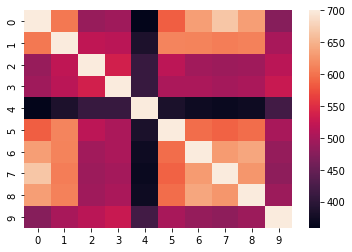

In [127]:
sns.heatmap(distances)

In [105]:
tasks_ordered = []
for task in range(0,15000,1500):
    tasks_ordered.append(samples.env_infos["task_name"][task])
tasks_ordered

['reach-v2',
 'push-v2',
 'pick-place-v2',
 'door-open-v2',
 'drawer-open-v2',
 'drawer-close-v2',
 'button-press-topdown-v2',
 'peg-insert-side-v2',
 'window-open-v2',
 'window-close-v2']

In [35]:
task_ids[0][0] += 1

In [36]:
task_ids

defaultdict(collections.Counter, {0: Counter({0: 1})})

# Run aggregate comparison

In [5]:
from collections import Counter, defaultdict

def calculate_distance_overlap(task_aggs):
    distances = np.zeros((10,10))
    for taskA in range(10):
        for taskB in range(10):
            distances[taskA][taskB] = (task_aggs[taskA] * task_aggs[taskB]).sum()
    return distances

def aggregate_representations(data, agg_by_kwinner=True):
    task_ids = {}
    task_aggs = {}

    # dictionary: task -> list of samples. 
    for task_id in range(10):
        task_ids[task_id] = torch.zeros(data[0][0].shape)
        num_samples = len(task_ids[task_id])
        for sample_tensor in data[task_id]:
            task_ids[task_id] += sample_tensor > 0

        if agg_by_kwinner:
            task_aggs[task_id] = torch.zeros(data[0][0].shape)       
            _, argmax_indices = torch.topk(task_ids[task_id], k=int(num_samples/4))
            task_aggs[task_id][argmax_indices] = 1    
        else:
            task_aggs[task_id] = task_ids[task_id] > num_samples * .50

    return task_aggs


<AxesSubplot:>

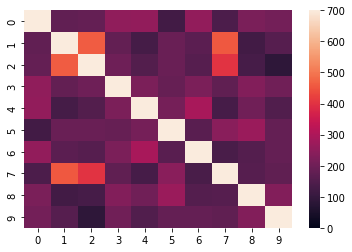

In [6]:
state_path = "/Users/lsouza/nta/results/no_preprocess3-wouv839/experiment_state.p"
config = "no_preprocess6"
dendrite_net, sampler = init_experiment(state_path, config, mlp=False)
dendrite_samples, dendrite_data = collect_data(dendrite_net, sampler, num_eval_eps=3)

dendrite_task_aggs = aggregate_representations(dendrite_data)
dendrite_distances = calculate_distance_overlap(dendrite_task_aggs)
sns.heatmap(dendrite_distances, vmin=0, vmax=700)

Running network with batch normalization
Sequential(
  (linear): Linear(in_features=2800, out_features=2800, bias=True)
  (layer_normalization): LayerNorm((2800,), eps=1e-05, elementwise_affine=True)
  (non_linearity): <built-in method relu of type object at 0x139730c90>
)
Using MLP network


<AxesSubplot:>

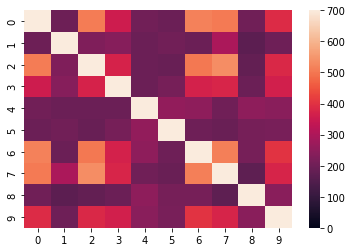

In [7]:
# state_path = "/Users/lsouza/nta/results/mlp_final-dtbi450/experiment_state.p"
state_path = "/Users/lsouza/nta/results/mlp_final-kqyg565/experiment_state.p"
config = "mlp_final"
mlp_net, sampler = init_experiment(state_path, config, mlp=True)
mlp_samples, mlp_data = collect_data(mlp_net, sampler, num_eval_eps=3)

mlp_task_aggs = aggregate_representations(mlp_data)
mlp_distances = calculate_distance_overlap(mlp_task_aggs)
sns.heatmap(mlp_distances, vmin=0, vmax=700)

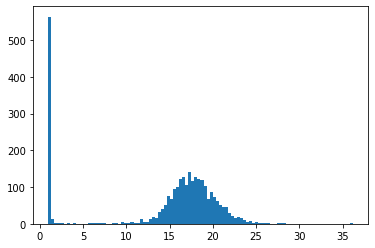

In [40]:
plt.hist(torch.norm(mlp_net.module.mean_log_std._layers[1].linear.weight.data, dim=0).numpy(), bins=100); 

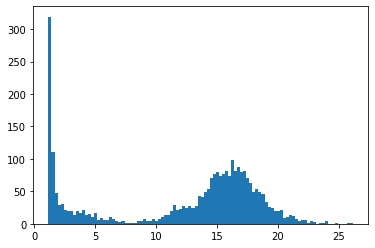

In [50]:
plt.hist(torch.norm(dendrite_net.module.mean_log_std.dendritic_module.layers[1].dendrite[0].module.weight.data, dim=0).numpy(), bins=100); 

In [65]:
def sum_representations(data, agg_by_kwinner=True):
    acts_sum = {}

    # dictionary: task -> list of samples. 
    for task_id in range(10):
        acts_sum[task_id] = torch.zeros(data[0][0].shape)
        num_samples = len(acts_sum[task_id])
        for sample_tensor in data[task_id]:
            acts_sum[task_id] += sample_tensor > 0

    return acts_sum


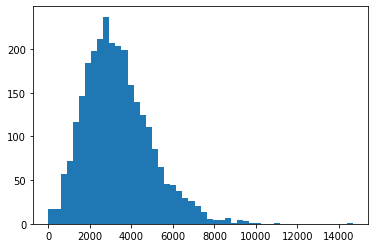

In [182]:
dendrite_acts_per_task = sum_representations(dendrite_data)
dendrite_acts = torch.stack([dendrite_acts_per_task[idx] for idx in range(10)]).sum(dim=0)
plt.hist(dendrite_acts.numpy(), bins=50);

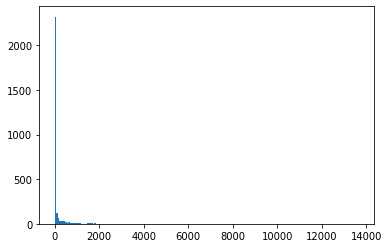

In [98]:
mlp_acts_per_task = sum_representations(mlp_data)
mlp_acts = torch.stack([mlp_acts_per_task[idx] for idx in range(10)]).sum(dim=0)
plt.hist(mlp_acts.numpy(), bins=200);

In [93]:
def aggregate_representations(data, agg_by_kwinner=True, topk=10):
    task_ids = {}
    task_aggs = {}

    # dictionary: task -> list of samples. 
    for task_id in range(10):
        task_ids[task_id] = torch.zeros(data[0][0].shape)
        num_samples = len(task_ids[task_id])
        for sample_tensor in data[task_id]:
            task_ids[task_id] += sample_tensor > 0

        if agg_by_kwinner:
            task_aggs[task_id] = torch.zeros(data[0][0].shape)       
            _, argmax_indices = torch.topk(task_ids[task_id], k=topk)
            task_aggs[task_id][argmax_indices] = 1    
        else:
            task_aggs[task_id] = task_ids[task_id] > num_samples * .50

    return task_aggs

<AxesSubplot:>

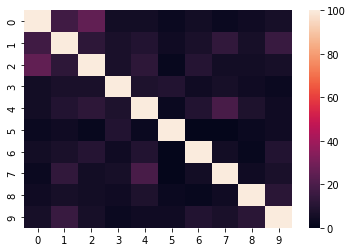

In [96]:
dendrite_task_aggs = aggregate_representations(dendrite_data, topk=100)
dendrite_distances = calculate_distance_overlap(dendrite_task_aggs)
sns.heatmap(dendrite_distances, vmin=0, vmax=100)

<AxesSubplot:>

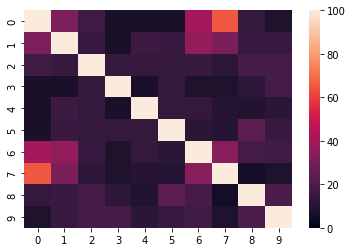

In [97]:
mlp_task_aggs = aggregate_representations(mlp_data, topk=100)
mlp_distances = calculate_distance_overlap(mlp_task_aggs)
sns.heatmap(mlp_distances, vmin=0, vmax=100)

Running network with batch normalization
Sequential(
  (linear): Linear(in_features=2800, out_features=2800, bias=True)
  (layer_normalization): LayerNorm((2800,), eps=1e-05, elementwise_affine=True)
  (non_linearity): <built-in method relu of type object at 0x13379dc90>
)
Using MLP network


<AxesSubplot:>

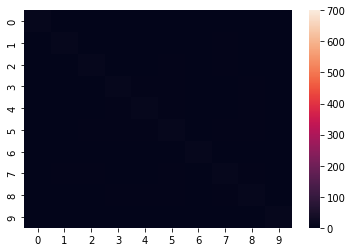

In [191]:
state_path = "/Users/lsouza/nta/results/mlp_final-kqyg565/experiment_state.p"
config = "mlp_final"
mlp2_net, sampler = init_experiment(state_path, config, mlp=True)
mlp2_samples, mlp2_data = collect_data(mlp2_net, sampler, num_eval_eps=3)

mlp2_task_aggs = aggregate_representations(mlp2_data)
mlp2_distances = calculate_distance_overlap(mlp2_task_aggs)
sns.heatmap(mlp2_distances, vmin=0, vmax=700)

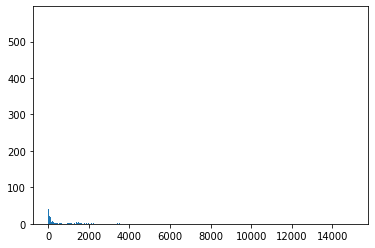

In [194]:
mlp2_acts_per_task = sum_representations(mlp2_data)
mlp2_acts = torch.stack([mlp2_acts_per_task[idx] for idx in range(10)]).sum(dim=0)
plt.hist(mlp2_acts.numpy(), bins=5000);

In [227]:
import pandas as pd
bins = pd.IntervalIndex.from_tuples([
    (-1, 1), (1, 2), (2, 3), (3,4), (4,5), (5,10), (10,50), 
    (50,200), (200, 1e3), (1e3, 1e4), (1e4, 1e5), (1e5, 1e6), (1e6, 15e6)
])
cut_df = pd.cut(mlp2_acts.numpy(), bins=bins, retbins=True)
cut_df[0].value_counts()

(-1.0, 1.0]                520
(1.0, 2.0]                  48
(2.0, 3.0]                  41
(3.0, 4.0]                  10
(4.0, 5.0]                  16
(5.0, 10.0]                 67
(10.0, 50.0]               425
(50.0, 200.0]              629
(200.0, 1000.0]            436
(1000.0, 10000.0]          606
(10000.0, 100000.0]          2
(100000.0, 1000000.0]        0
(1000000.0, 15000000.0]      0
dtype: int64

In [185]:
mlp2_net

GaussianMLPPolicy(
  (module): GaussianTwoHeadedMLPModule(
    (mean_log_std): CustomMultiHeadedMLPModule(
      (_layers): ModuleList(
        (0): Sequential(
          (linear): Linear(in_features=49, out_features=2800, bias=True)
          (layer_normalization): LayerNorm((2800,), eps=1e-05, elementwise_affine=True)
          (non_linearity): <built-in method relu of type object at 0x13379dc90>
        )
        (1): Sequential(
          (linear): Linear(in_features=2800, out_features=2800, bias=True)
          (layer_normalization): LayerNorm((2800,), eps=1e-05, elementwise_affine=True)
          (non_linearity): <built-in method relu of type object at 0x13379dc90>
        )
      )
      (_output_layers): ModuleList(
        (0): Sequential(
          (linear): Linear(in_features=2800, out_features=4, bias=True)
        )
        (1): Sequential(
          (linear): Linear(in_features=2800, out_features=4, bias=True)
        )
      )
    )
  )
)

In [135]:
t = torch.randn(2800) + 1

(array([406.,  65., 357., 935., 779., 211.,  30.,   9.,   4.,   4.]),
 array([0.        , 0.02139219, 0.04278439, 0.06417658, 0.08556877,
        0.10696097, 0.12835316, 0.14974536, 0.17113754, 0.19252974,
        0.21392193], dtype=float32),
 <BarContainer object of 10 artists>)

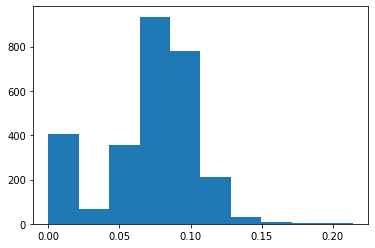

In [137]:
output = mlp2_net.module.mean_log_std._layers[1](t).numpy()
plt.hist(output)

(array([406.,  65., 357., 935., 779., 211.,  30.,   9.,   4.,   4.]),
 array([0.        , 0.02139219, 0.04278439, 0.06417658, 0.08556877,
        0.10696097, 0.12835316, 0.14974536, 0.17113754, 0.19252974,
        0.21392193], dtype=float32),
 <BarContainer object of 10 artists>)

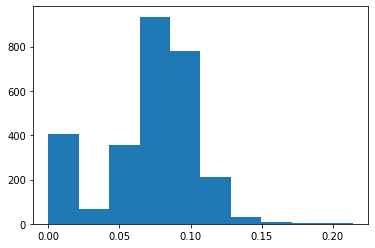

In [140]:
output = (mlp2_net.module.mean_log_std._layers[1].linear(t))
output = (mlp2_net.module.mean_log_std._layers[1].layer_normalization(output))
output = mlp2_net.module.mean_log_std._layers[1].non_linearity(output).numpy()
plt.hist(output)

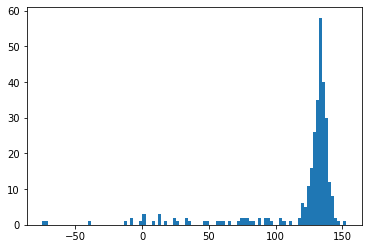

In [166]:
output = (mlp2_net.module.mean_log_std._layers[1].linear(t)).numpy()
plt.hist(output[0:300], bins=100);
# plt.xlim(-10,10);

In [163]:
output[200:300]

array([ -1.8558567, 143.17714  , 128.42935  , 119.52765  ,  88.68819  ,
       137.76205  ,  58.68021  , 131.95468  , 140.90437  , 133.70308  ,
       137.9316   ,  23.576952 , 126.73367  , 131.58778  , 134.77649  ,
       105.13374  , 132.74506  , 137.04509  , 133.77206  , 141.1385   ,
       138.26137  , 143.57072  , 127.8223   , 138.6389   , 132.2731   ,
       106.13305  ,  34.389984 , 135.82623  , 131.39124  , 133.80388  ,
       138.68471  , 132.30759  , 120.2593   , 137.10165  , 129.71275  ,
       134.11337  , 133.0587   , 137.6672   , 127.933975 , 139.20258  ,
        77.79921  , 137.70805  , 133.59932  , 130.21208  , 127.92736  ,
       133.87944  , 138.80554  , 133.98073  , 142.1621   , 133.09825  ,
       139.78241  , 135.0645   ,  91.89309  , 133.09602  , 143.07954  ,
       133.84091  , 136.35439  , 141.85616  , 133.78532  , 134.34096  ,
       129.75748  , 125.261795 , 125.11522  , 133.82072  , 131.10158  ,
       130.17227  , 123.24305  , 134.98978  , 135.9063   , 134.4

(array([  2.,   1.,   3.,   8.,   7.,   5.,  10.,  10.,  67., 187.]),
 array([-5.2491446 , -4.6333375 , -4.0175304 , -3.4017239 , -2.7859168 ,
        -2.1701097 , -1.5543029 , -0.938496  , -0.32268906,  0.29311788,
         0.9089248 ], dtype=float32),
 <BarContainer object of 10 artists>)

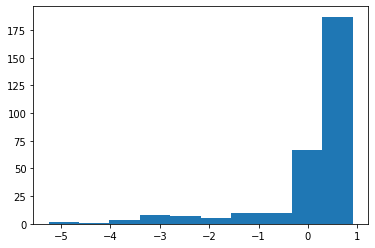

In [171]:
seq = torch.nn.Sequential(
    torch.nn.LayerNorm(300, elementwise_affine=False),
)
normalized_output = seq(torch.tensor(output[0:300])).numpy()
plt.hist(normalized_output)

In [174]:
(normalized_output < 0).sum()

50

In [177]:
output[0:300].min(), output[0:300].max(), output[0:300].mean(), output[0:300].std()

(-74.8436, 152.97675, 119.35069, 36.995434)

In [178]:
((output[0:300] - output[0:300].mean()) > 0).sum()

250

In [176]:
t = torch.randn(20) + 1
t

tensor([ 0.7534,  3.0042,  1.5052,  1.1599, -0.1500, -0.0540,  0.2976,  0.4202,
        -0.1452,  0.6280,  1.1217,  0.4130, -0.4011,  0.5769, -0.2324, -0.2509,
         0.9102,  1.3639,  0.9206,  2.7622])

In [111]:
seq = torch.nn.Sequential(
    torch.nn.LayerNorm(20, elementwise_affine=False),
    torch.nn.ReLU()
)
seq(t)

tensor([0.9813, 0.0000, 0.6811, 0.0000, 0.9045, 0.5314, 1.5788, 0.2789, 0.0000,
        0.0000, 0.0000, 0.8979, 0.0000, 0.0000, 0.6219, 0.7872, 0.0000, 0.0000,
        1.1951, 0.1607])